In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gzbuilderspirals import xy_from_r_theta
from gzbuilderspirals.oo import Pipeline

In [3]:
t = np.linspace(1, 2*np.pi+1)

In [4]:
def log_spiral(a, b, t=t, dt=0):
    return a * np.exp(b * t), t+dt

def poly_spiral(p, t=t, dt=0):
    return np.add.reduce([
        t**(i + 1) * p[i] for i in range(len(p))
    ], axis=0) + 20, t + dt

def gen_noisy_arm_from_tpl(template, v=4):
    ltp = np.clip(np.random.randn()+1, 0, 3)
    large_scale_noise = (np.sin(ltp*template[1]) - 0.5) * np.random.randn()*v*3
    r_n = template[0] \
        + np.random.randn(len(template[0])) * v \
        + large_scale_noise
    return r_n, template[1] + np.random.randn() * v * 0.05

def translate_arm(arm):
    return np.array(arm) + 256.0

In [5]:
p1 = [20]
p2 = [0, 2.8]
p3 = [0, 0, 0.45]

template_1_0 = poly_spiral(p1)
template_1_1 = poly_spiral(p1, dt=np.pi)
template_2_0 = poly_spiral(p2)
template_2_1 = poly_spiral(p2, dt=np.pi)
template_3_0 = poly_spiral(p3)
template_3_1 = poly_spiral(p3, dt=np.pi)

In [6]:
drawn_arms = [
    [
        np.stack(xy_from_r_theta(*gen_noisy_arm_from_tpl(t0)), axis=1) + 256
        for i in range(10)
    ] + [
        np.stack(xy_from_r_theta(*gen_noisy_arm_from_tpl(t1)), axis=1) + 256
        for i in range(10)
    ]
    for t0, t1 in (
        (template_1_0, template_1_1),
        (template_2_0, template_2_1),
        (template_3_0, template_3_1)
    )
]

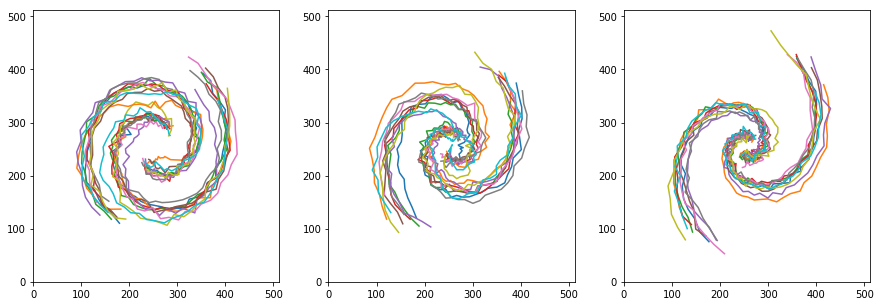

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for arms, ax in zip(drawn_arms, axes):
    plt.sca(ax)
    plt.xlim(0, 512)
    plt.ylim(0, 512)
    for arm in arms:
        plt.plot(*arm.T)

In [8]:
pipelines = [
    Pipeline(arms, phi=0, ba=1, image_size=512,
             distances=None, parallel=True, bar_length=10)
    for arms in drawn_arms
]

In [9]:
arm_pairs = [
    p.get_arms()
    for p in pipelines
]

/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (16). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  % (self.n_neighbors, n_samples))
/Users/tlingard/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:253: UserWarning: n_neighbors (20) is greater than the total number of samples (17). n_neighbors will be set to (n_samples - 1) for estimation.
  %

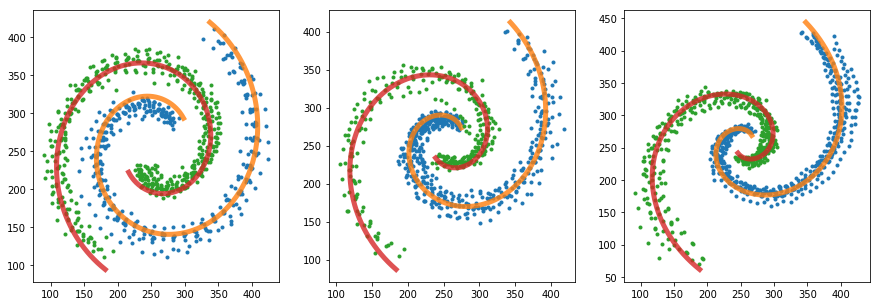

In [14]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for arms, ax in zip(arm_pairs, axes):
    for a in arms:
        ax.plot(*a.coords[a.outlier_mask].T, '.')
        ax.plot(*a.reprojected_log_spiral.T, linewidth=5, alpha=0.8)

In [11]:
from IPython.display import display
from sklearn.metrics import r2_score

for i, arms in enumerate(arm_pairs):
    _, scores0 = arms[0].fit_polynomials()
    _, scores1 = arms[1].fit_polynomials()
    avg_scores = (pd.DataFrame(scores0).mean(axis=0) + pd.DataFrame(scores1).mean(axis=0)) / 2
    print('For spiral of degree {}'.format(i + 1))
    print('Best model:', avg_scores.idxmax())
    display(avg_scores)

For spiral of degree 1
Best model: poly_spiral_2


poly_spiral_1   -0.013731
poly_spiral_2   -0.013155
poly_spiral_3   -0.013819
poly_spiral_4   -0.013620
log_spiral      -0.017354
dtype: float64

For spiral of degree 2
Best model: poly_spiral_2


poly_spiral_1   -0.018834
poly_spiral_2   -0.013093
poly_spiral_3   -0.013209
poly_spiral_4   -0.013537
log_spiral      -0.014052
dtype: float64

For spiral of degree 3
Best model: log_spiral


poly_spiral_1   -0.025438
poly_spiral_2   -0.012879
poly_spiral_3   -0.013268
poly_spiral_4   -0.013286
log_spiral      -0.012457
dtype: float64